In [76]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import cv2
import os
from numpy.linalg import svd, matrix_rank

import sys
sys.path.append("../utils")

from utils_3d import *

# load data 

In [78]:
# sample dataset directory
sample_data_path = "../ImageDataset_SceauxCastle/images/"

K = np.loadtxt(os.path.join(sample_data_path,"K.txt"))

In [127]:
im1 = cv2.imread(os.path.join(sample_data_path,"100_7103.JPG"))
im2 = cv2.imread(os.path.join(sample_data_path,"100_7106.JPG"))

In [128]:
# gray
im1_gray = cv2.cvtColor(im1,cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_RGB2GRAY)

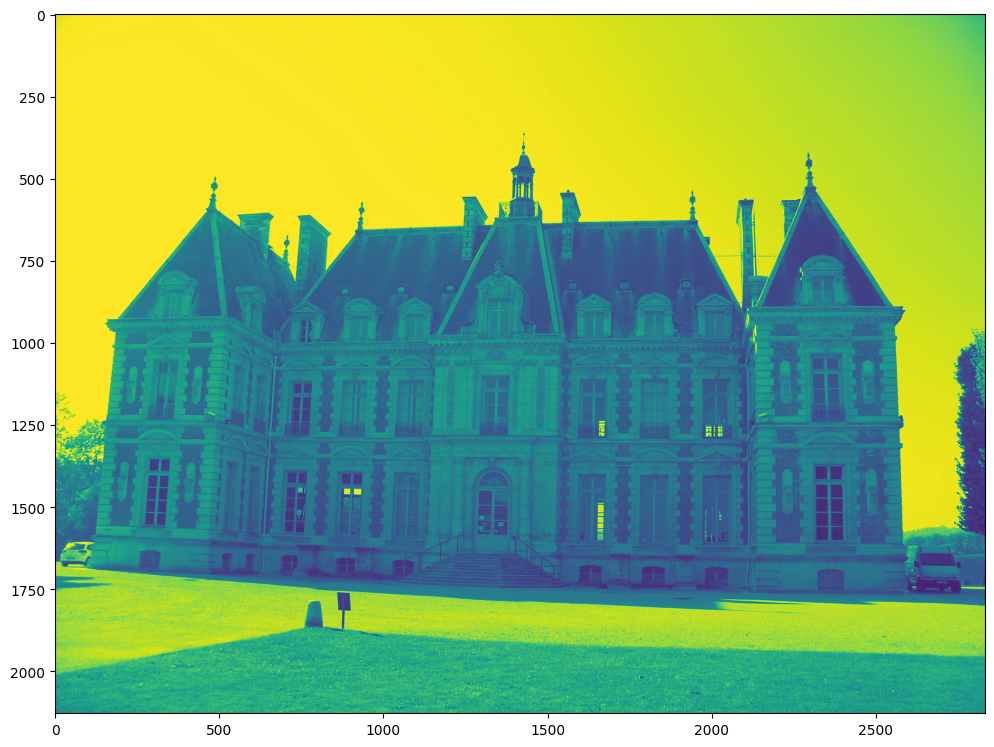

In [129]:
imshow(im2_gray)

# matching sift

In [130]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(im1_gray,None)
kp2, des2 = sift.detectAndCompute(im2_gray,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append(match1)

#sift_matches = cv2.drawMatchesKnn(im1_gray,kp1,im2_gray,kp2,good,None,flags=2)

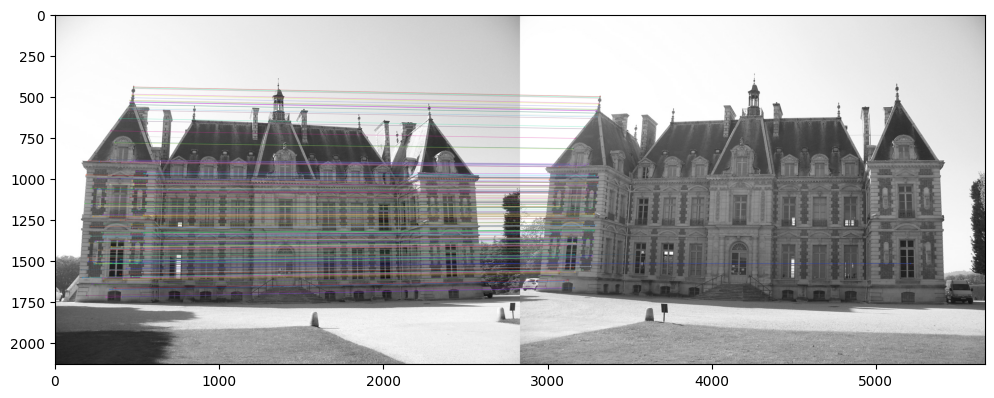

In [131]:
pts1 = []
pts2 = []

for i,m in enumerate(good):
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

good_matches_inliers = [m for i,m in enumerate(good) if mask[i,0] == 1]

img_good_matches_inliers = cv2.drawMatches(im1_gray,kp1,im2_gray,kp2,good_matches_inliers[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

# Extract R ,t by Fundamental matrix and K
* F = K^(-T)EK^(-1)
* E = K^(T)FK
* E= [t]xR

In [132]:
def traiangulate_point(R1,t1,R2,t2,pt1,pt2,invK):

    A = np.zeros((6,6))
    
    p1 = invK.dot(np.array([pt1[0],pt1[1],1]))
    p2 = invK.dot(np.array([pt2[0],pt2[1],1]))
    
    A[0:3,:3] = R1.T
    A[0:3,3] = -R1.T.dot(t1)
    A[3:6,:3] = R2.T
    A[3:6,3] = -R2.T.dot(t2)
    A[0:3,4] = -p1
    A[3:6,5] = -p2

    U,S,Vh = np.linalg.svd(A)
    X = Vh[-1,:4]

    a = (X / X[3])[:3]
    
    return a

In [138]:
def decomposeE2Rt_and_calc_Xs_wrt_v1(F,K):
    
    E = K.T.dot(F).dot(K)
    
    U,D,Vh = svd(E)
    
    # |R| = 1 is required to rotation matrix. Otherwise R = -R,t=-t is correct transformation.
    if np.linalg.det(U.dot(Vh))<0:
        print("dd")
        Vh = -Vh
    
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    candidates_v1Pv2 = np.zeros((4,3)) # v2_v1Pv2
    candidates_v2Rv1 = np.zeros((4,3,3)) # v1Rv2

    candidates_v1Pv2[0] = U.T[2,:]
    candidates_v2Rv1[0] = U.dot(W).dot(Vh)

    candidates_v1Pv2[1] = -U.T[2,:]
    candidates_v2Rv1[1] = U.dot(W).dot(Vh)

    candidates_v1Pv2[2] = U.T[2,:]
    candidates_v2Rv1[2] = U.dot(W.T).dot(Vh)

    candidates_v1Pv2[3] = -U.T[2,:]
    candidates_v2Rv1[3] = U.dot(W.T).dot(Vh)

    # find correct geometory of R and t and execute traiangulation
    triad_positive_depth_counts = np.zeros(4)
    triad_v1Xs = []
    
    for cand_idx,(cand_v1Pv2,cand_v2Rv1) in enumerate(zip(candidates_v1Pv2,candidates_v2Rv1 )):
        
        triad_inliers_mask = np.zeros(pts1.shape[0])
        v1Xs = []
        
        for i,(pt1,pt2) in enumerate(zip(pts1_inliers,pts2_inliers)):
            wRv1 = np.eye(3)
            wPv1 = np.zeros(3)
            wRv2 = wRv1.dot(cand_v2Rv1.T)
            wPv2 = wPv1 + cand_v1Pv2
            v1X = traiangulate_point(wRv1,wPv1,wRv2,wPv2,pt1,pt2,np.linalg.inv(K))

            # check the sign of projected vector along camera axi
            flag = v1X[2] > 0 and cand_v2Rv1[:,2].dot(v1X - cand_v1Pv2) > 0
            if flag:
                v1Xs.append(v1X)
                triad_inliers_mask[i] = 1 
            
        triad_positive_depth_counts[cand_idx] = np.count_nonzero(triad_inliers_mask)
        triad_v1Xs.append(v1Xs)
        
    ans_cand_idx = triad_positive_depth_counts.argmax()
    w_v1Pv2 = candidates_v1Pv2[ans_cand_idx]
    v2Rv1 = candidates_v2Rv1[ans_cand_idx,:,:]
    v1Lmks = np.array(triad_v1Xs[ans_cand_idx]).squeeze()
    print("candidate idx:{:d}".format(ans_cand_idx))
    return w_v1Pv2,v2Rv1,v1Lmks

In [139]:
v1Pv2,v2Rv1,v1Lmks = decomposeE2Rt_and_calc_Xs_wrt_v1(F,K)

dd
candidate idx:3


In [140]:
np.linalg.det(v2Rv1)

0.9999999999999999

# view

In [141]:
out_pcl_file_name = "/home/leo/work/sfm/viewer/webgl/static/model/old/model_test2.ply"
out_camera_file_name = "/home/leo/work/sfm/viewer/webgl/static/model/old/camera2.ply"

In [142]:
wPv1 = np.array([0,0,0])
wRv1 = np.eye(3)

wLmks = wRv1.dot(v1Lmks.T).T + wPv1
save_3dpoints_ply(5*wLmks,out_pcl_file_name,True,False)

wRv2 = wRv1.dot(v2Rv1.T)
wPv2 = wPv1 + wRv2.dot(v1Pv2)

Ps = np.vstack([wPv1,wPv2])
Rs= np.stack([wRv1,wRv2])

generate_multiple_camera_ply(5*Ps,Rs,out_camera_file_name,[0,255,0],False)